### Imports

In [8]:
from utils.utils import *

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import scipy
import sys

### Parameters

In [9]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

exp = params["exp"]
print("Exp:\t\t", exp)

methods = ["vgae", "vgae"]
print("Methods:\t", methods)

groups = ["Starved", "FCSglc"]
print("Groups:\t\t", groups)

options = ["dyn", "dyn"]
print("Options:\t", options)

Exp:		 exp8
Methods:	 ['vgae', 'vgae']
Groups:		 ['Starved', 'FCSglc']
Options:	 ['dyn', 'dyn']


In [10]:
def sort_edges(df_edges):
    s = []
    t = []
    for row in df_edges.itertuples():
        if row[1] > row[2]:
            s.append(row[2])
            t.append(row[1])
        else:
            s.append(row[1])
            t.append(row[2])
    df_edges["source"] = s
    df_edges["target"] = t

### Changes detection

#### Read edges

In [11]:
list_graphs = []
for k in range(len(groups)):
    df_edges = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, methods[k], groups[k], options[k]),
                            dtype={"source": "string", "target": "string"})
    sort_edges(df_edges)
    df_edges.rename(columns={"weight": "weight{}".format(k + 1)}, inplace=True)
    G = nx.from_pandas_edgelist(df_edges, edge_attr=["weight{}".format(k + 1)])
    
    list_graphs.append(G)

#### Compose

In [12]:
R = nx.compose(list_graphs[0], list_graphs[1])

labels = []
for edge in R.edges():
    weights = R.get_edge_data(*edge)
    label = get_label(weights)
    labels.append(label)
labels

nx.set_edge_attributes(R, {(u, v): {"change": get_label(ed, th=0.8)} for u, v, ed in R.edges.data()})

In [13]:
df_change = nx.to_pandas_edgelist(R)
df_change = df_change[["source", "target", "weight1", "weight2", "change"]]
df_change

,source,target,weight1,weight2,change
0,100.00072,1015.62897,-1.0,NaN,N?
1,100.00072,1033.15576,1.0,NaN,P?
2,100.00072,1039.01721,1.0,NaN,P?
3,100.00072,1040.8479,1.0,NaN,P?
4,100.00072,1045.24829,1.0,-1.0,PN
...,...,...,...,...,...
1893231,986.77826,149.06078,NaN,-1.0,?N
1893232,986.77826,163.06113,NaN,-1.0,?N
1893233,149.06078,166.06375,NaN,1.0,?P
1893234,163.06113,218.94775,NaN,1.0,?P


In [14]:
# df_change = df_change.fillna(0)
# df_change

### Differences between correlations

In [15]:
def fisher_transform(r):
    # z = 0.5 * (np.log(1 + r) - np.log(1 - r))
    return 0.5 * np.log((1 + r) / (1 - r))

In [16]:
# option 1
n1 = len(df_change)
n2 = len(df_change)

z1 = fisher_transform(df_change["weight1"])
z2 = fisher_transform(df_change["weight2"])

sezdiff = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))

ztest = (z1 - z2) / sezdiff

p_value = 2 * (1 - scipy.stats.norm.cdf(np.abs(ztest), loc=0, scale=1))

df_change["p_value"] = p_value
df_change

/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,source,target,weight1,weight2,change,p_value
0,100.00072,1015.62897,-1.0,NaN,N?,NaN
1,100.00072,1033.15576,1.0,NaN,P?,NaN
2,100.00072,1039.01721,1.0,NaN,P?,NaN
3,100.00072,1040.8479,1.0,NaN,P?,NaN
4,100.00072,1045.24829,1.0,-1.0,PN,NaN
...,...,...,...,...,...,...
1893231,986.77826,149.06078,NaN,-1.0,?N,NaN
1893232,986.77826,163.06113,NaN,-1.0,?N,NaN
1893233,149.06078,166.06375,NaN,1.0,?P,NaN
1893234,163.06113,218.94775,NaN,1.0,?P,NaN


In [17]:
df_change.describe()

,weight1,weight2,p_value
count,1.204011e+06,1.148220e+06,129591.000000
mean,1.677809e-02,3.072059e-02,0.012447
std,9.998597e-01,9.995284e-01,0.110869
min,-1.000000e+00,-1.000000e+00,0.000000
25%,-1.000000e+00,-1.000000e+00,0.000000
50%,1.000000e+00,1.000000e+00,0.000000
75%,1.000000e+00,1.000000e+00,0.000000
max,1.000000e+00,1.000000e+00,1.000000


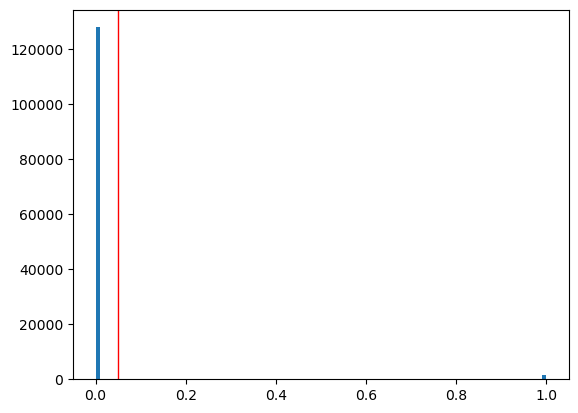

In [18]:
x = df_change["p_value"]
plt.hist(x, bins=100)
plt.axvline(x=0.05, color="red", lw=1)
l = len(df_change) - len(df_change)
t = len(df_change)
# plt.title("Loss: {} of {} ({}%)".format(l, t, round(l*100/t)))
# plt.savefig("output/{}/plots/common_edges_std_{}_{}_{}.png".format(exp, method, group, option))
plt.show()
# plt.clf()

In [19]:
df_change_filter = df_change[df_change["p_value"] < 0.05]
df_change_filter

,source,target,weight1,weight2,change,p_value
56,100.00072,183.11513,-1.0,-1.0,NN,0.0
81,100.00072,218.00537,1.0,-1.0,PN,0.0
142,100.00072,289.02216,-1.0,-1.0,NN,0.0
147,100.00072,291.6264,1.0,1.0,PP,0.0
154,100.00072,294.01767,1.0,1.0,PP,0.0
...,...,...,...,...,...,...
1891851,111.05032,196.07112,-1.0,-1.0,NN,0.0
1891854,111.05032,998.30731,1.0,-1.0,PN,0.0
1891892,319.11441,998.30731,-1.0,-1.0,NN,0.0
1891982,998.30731,196.07112,-1.0,1.0,NP,0.0


In [20]:
df_change_filter.describe()

,weight1,weight2,p_value
count,127978.000000,127978.000000,1.279780e+05
mean,0.019050,0.026348,4.872858e-10
std,0.999822,0.999657,1.741676e-07
min,-1.000000,-1.000000,0.000000e+00
25%,-1.000000,-1.000000,0.000000e+00
50%,1.000000,1.000000,0.000000e+00
75%,1.000000,1.000000,0.000000e+00
max,1.000000,1.000000,6.230673e-05


### Query

In [97]:
df_aux = df_change[(df_change["weight1"].notnull()) & (df_change["weight2"].notnull())].iloc[0:60]
# df_change[df_change["change"] == "Nn"]
df_aux

,source,target,weight1,weight2,change
1,100.9679,260.9136,0.671584,0.826581,pP
44,176.975,221.9332,0.822886,0.820336,PP
45,176.975,242.9038,0.825561,0.816429,PP
46,176.975,256.9201,0.827404,0.857583,PP
47,176.975,258.9161,0.839292,0.845274,PP
48,176.975,260.9136,0.829062,0.864594,PP
49,176.975,263.9094,0.759112,0.734227,pp
52,176.975,515.2878,0.813129,0.838789,PP
289,260.9136,123.9906,0.776854,0.869177,pP
290,260.9136,139.007,0.735176,0.855997,pP


In [98]:
node = "59.0137"
df_change[(df_change["source"] == node) | (df_change["target"] == node)]

,source,target,weight1,weight2,change
8955,176.9495,59.0137,NaN,0.658217,?p
42554,129.0192,59.0137,NaN,0.759928,?p
44156,148.0493,59.0137,NaN,0.795262,?p
50803,237.0282,59.0137,NaN,0.779185,?p
75929,284.9032,59.0137,NaN,0.647598,?p
121202,238.903,59.0137,NaN,0.696979,?p
122272,258.9891,59.0137,NaN,0.712497,?p
158816,260.0924,59.0137,NaN,0.658420,?p
169239,301.1298,59.0137,NaN,0.609237,?p
412679,441.2525,59.0137,NaN,0.775983,?p


In [99]:
l = ['59.0137', '71.0139', '74.0249', '85.0296', '87.0086', '88.0405',
       '89.0245', '101.0243', '102.0562', '109.0407', '112.0518', '113.0246',
       '115.0038', '117.0195', '118.051', '118.9807', '122.0247', '128.0355',
       '129.0192', '130.0506', '130.0875', '131.0355', '131.0824', '132.0303',
       '133.014', '135.0311', '145.0144', '145.0617', '145.0984', '146.0458',
       '147.0297', '147.0655', '151.0403', '152.0354', '153.0173', '154.062',
       '165.0554', '166.0506', '166.9758', '168.0663', '171.0302', '173.0095',
       '173.0454', '173.0711', '179.0348', '179.0561', '184.0021', '186.1139',
       '211.0603', '213.0145', '218.1033', '225.0991', '237.0282', '249.0552',
       '251.0776', '259.0227', '266.0886', '279.2331', '307.0311', '316.2857',
       '317.2143', '323.0277', '338.9889', '346.0558', '347.0589', '362.0509',
       '365.0531', '367.0185', '388.9441', '397.1319', '401.0173', '426.0221',
       '441.3372', '489.9937', '505.9889', '521.984', '545.3994', '604.0696',
       '606.0744', '611.144', '664.117', '665.2139', '766.1076', '784.1495',
       '808.118']

for node in l:
    aux = df_aux[(df_aux["source"] == node) | (df_aux["target"] == node)]
    if len(aux) > 0:
       print(aux)

       source    target   weight1   weight2 change
645  102.0562  131.0824  0.785957  0.883519     pP
646  102.0562   133.014  0.767492  0.840669     pP
647  102.0562  138.9644  0.695808  0.787141     pp
650  102.0562  154.9474  0.667261  0.797327     pp
658  102.0562  176.9495  0.686465  0.823850     pP
659  102.0562  177.9493  0.655557  0.787066     pp
663  102.0562  220.9927  0.633311  0.816565     pP
        source    target   weight1   weight2 change
645   102.0562  131.0824  0.785957  0.883519     pP
1400  131.0824  129.0385  0.816162  0.910353     PP
1403  131.0824   139.007  0.751100  0.815330     pP
1413  131.0824  165.0753  0.773576  0.883794     pP
1414  131.0824  168.0277  0.830237  0.898015     PP
1415  131.0824  173.1294  0.826079  0.911907     PP
       source   target   weight1   weight2 change
646  102.0562  133.014  0.767492  0.840669     pP


---

In [100]:
H = nx.from_pandas_edgelist(df_change, "source", "target", edge_attr=["change"], create_using=nx.DiGraph())
# H.edges(data=True)

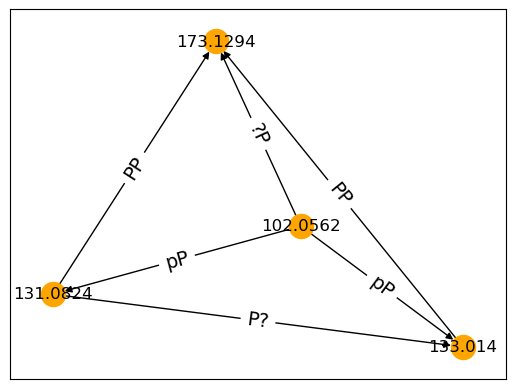

In [107]:
# HF = H.subgraph(["127.0513", "132.086", "145.0507", "980.0155", "132.086", "115.0038"])
HF = H.subgraph(["102.0562", "131.0824", "133.014", "173.1294"])
edge_labels = nx.get_edge_attributes(HF, "change")

pos = pos=nx.spring_layout(HF)
nx.draw_networkx(HF, pos, font_color="black", font_size=12, node_color="orange")
nx.draw_networkx_edge_labels(H, pos, edge_labels, font_size=14)

# plt.title("{}: {} --> {}".format(method, group1[0], group2[0]))
plt.show()